<a href="https://colab.research.google.com/github/tleitch/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/assignments/projectOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mean-Variance Optimization

MPT solves for the optimal portfolio weights to minimize volatility for a given expected return, or maximize returns for a given level of volatility. The key requisite input are expected asset returns, standard deviations, and the covariance matrix. 

Diversification works because the variance of portfolio returns depends on the covariance of the assets and can be reduced below the weighted average of the asset variances by including assets with less than perfect correlation. In particular, given a vector, ω, of portfolio weights and the covariance matrix, $\Sigma$, the portfolio variance, $\sigma_{\text{PF}}$ is defined as:
$$\sigma_{\text{PF}}=\omega^T\Sigma\omega$$

Markowitz showed that the problem of maximizing the expected portfolio return subject to a target risk has an equivalent dual representation of minimizing portfolio risk subject to a target expected return level, $μ_{PF}$. Hence, the optimization problem becomes:
$$
\begin{align}
\min_\omega & \quad\quad\sigma^2_{\text{PF}}= \omega^T\Sigma\omega\\
\text{s.t.} &\quad\quad \mu_{\text{PF}}= \omega^T\mu\\ 
&\quad\quad \lVert\omega\rVert =1
\end{align}
$$

We can calculate an efficient frontier using `scipy.optimize.minimize` and the historical estimates for asset returns, standard deviations, and the covariance matrix. 

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy.random import random, uniform, dirichlet, choice
from numpy.linalg import inv

from scipy.optimize import minimize

import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
!pip install backtrader
!pip install git+https://github.com/quantopian/pyfolio
!pip install yfinance
!pip install --upgrade tables
import backtrader as bt
from backtrader.feeds import PandasData
import pyfolio as pf
import yfinance as yf
from datetime import datetime
from datetime import date

Requirement already up-to-date: tables in /usr/local/lib/python3.7/dist-packages (3.6.1)


In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)

## Prepare Data

In [6]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


We select historical data for tickers included in the S&P500 (according to Wikipedia) from 1998-2017.

In [7]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
df = pd.read_html(url, header=0)[0]

In [8]:

df.columns = ['ticker', 'name', 'sec_filings', 'gics_sector', 'gics_sub_industry',
              'location', 'first_added', 'cik', 'founded']
df = df.drop('sec_filings', axis=1).set_index('ticker')

In [9]:

with pd.HDFStore('/content/drive/MyDrive/ahfs/assets.h5') as store:
    store.put('sp500/stocks', df)

In [10]:
with pd.HDFStore('/content/drive/MyDrive/ahfs/assets.h5') as store:
    sp500_stocks = store['sp500/stocks']

In [11]:
sp500_stocks.head()

,name,gics_sector,gics_sub_industry,location,first_added,cik,founded
ticker,,,,,,,
MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
ABMD,Abiomed,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [12]:
with pd.HDFStore('/content/drive/MyDrive/ahfs/assets.h5') as store:
    prices = (store['quandl/wiki/prices']
              .adj_close
              .unstack('ticker')
              .filter(sp500_stocks.index)
              .sample(n=30, axis=1))

## Compute Inputs

In [69]:
startDt='2014-01-01'
endDt='2017-12-31'

In [63]:
ff_factor = 'F-F_Research_Data_5_Factors_2x3_daily'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start=startDt, end=endDt)[0]
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 988 entries, 2014-01-02 to 2017-12-01
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  988 non-null    float64
 1   SMB     988 non-null    float64
 2   HML     988 non-null    float64
 3   RMW     988 non-null    float64
 4   CMA     988 non-null    float64
 5   RF      988 non-null    float64
dtypes: float64(6)
memory usage: 54.0 KB


In [91]:
#data = np.genfromtxt(,delimiter=',',skip_header=1)
import glob



# get data file names

local_path = r'/content/drive/MyDrive/ahfs/project'

filenames = glob.glob(local_path + "/*.csv")

dfs = []

i=0
for filename in filenames:
    if i==0:
      assetName=filename.rsplit( ".", 1 )[ 0 ]
      assetName=assetName.rsplit( "/", 1 )[ 1 ]
      print(assetName)
      dfs=pd.read_csv(filename)
      dfs.rename(columns={ dfs.columns[i+1]: assetName }, inplace = True)
    else:
      assetName=filename.rsplit( ".", 1 )[ 0 ]
      assetName=assetName.rsplit( "/", 1 )[ 1 ]
      ts=pd.read_csv(filename)
      ts.head()
      dfs=dfs.merge(ts,on="index")
      dfs.rename(columns={ dfs.columns[i+1]: assetName }, inplace = True)
    i=i+1




sma1


In [92]:
dfs.head()
dfs['Date']=dfs['index']
dfs['Date'] = pd.to_datetime(dfs['Date'],utc=False)
dfs.index=dfs['Date']

dfs=dfs.drop("index",axis=1)
dfs=dfs.drop("Date",axis=1)
dfs=dfs.tz_convert(None)

In [94]:
dfs=pd.merge(dfs, ff_factor_data/100, left_index=True, right_index=True)

In [95]:
dfs.head()

,sma1,sma1v2,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,,,
2015-07-06,0.0,0.0,-0.0037,0.0011,-0.0058,-0.0023,-0.0018,0.0
2015-07-07,0.0,0.0,0.0053,-0.0047,-0.0026,0.0041,-0.0001,0.0
2015-07-08,0.0,0.0,-0.0168,-0.0003,0.0008,0.0012,0.0013,0.0
2015-07-09,0.0,0.0,0.0029,0.0017,0.0000,-0.0028,-0.0026,0.0
2015-07-10,0.0,0.0,0.0124,0.0019,-0.0053,-0.0021,-0.0006,0.0


# Pick tickers here using mutual funds and ETF's for alternative benchmarks

In [96]:
numCol=len(dfs.columns)
tickers = ["MNA","ICVT","AQMNX"]
i=0
for ticker in tickers:
    data=yf.download(ticker,startDt, endDt)    
    rets=data['Adj Close'].pct_change()
    dfs=pd.merge(dfs, rets, left_index=True, right_index=True)
    dfs.rename(columns={ dfs.columns[numCol+i]: ticker }, inplace = True)
    i=i+1


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [97]:
dfs.head()

,sma1,sma1v2,Mkt-RF,SMB,HML,RMW,CMA,RF,MNA,ICVT,AQMNX
Date,,,,,,,,,,,
2015-07-07,0.0,0.0,0.0053,-0.0047,-0.0026,0.0041,-0.0001,0.0,-0.007251,-0.017245,0.008523
2015-07-09,0.0,0.0,0.0029,0.0017,0.0000,-0.0028,-0.0026,0.0,0.002094,0.010874,-0.021596
2015-07-10,0.0,0.0,0.0124,0.0019,-0.0053,-0.0021,-0.0006,0.0,0.003482,0.002483,-0.004798
2015-07-14,0.0,0.0,0.0047,0.0011,0.0014,-0.0035,-0.0036,0.0,0.001391,0.005538,0.001929
2015-07-16,0.0,0.0,0.0078,-0.0025,-0.0064,-0.0025,-0.0066,0.0,-0.001045,0.000000,0.013474


### Compute Returns

Create month-end monthly returns and drop dates that have no observations:

In [243]:
weekly_returns= dfs.resample('W').sum().dropna(how='all')
weekly_returns.info()
weekly_returns=weekly_returns.drop(columns=["sma1v2"])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 126 entries, 2015-07-12 to 2017-12-03
Freq: W-SUN
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sma1    126 non-null    float64
 1   sma1v2  126 non-null    float64
 2   Mkt-RF  126 non-null    float64
 3   SMB     126 non-null    float64
 4   HML     126 non-null    float64
 5   RMW     126 non-null    float64
 6   CMA     126 non-null    float64
 7   RF      126 non-null    float64
 8   MNA     126 non-null    float64
 9   ICVT    126 non-null    float64
 10  AQMNX   126 non-null    float64
dtypes: float64(11)
memory usage: 11.8 KB


In [244]:
weekly_returns.tail()

,sma1,Mkt-RF,SMB,HML,RMW,CMA,RF,MNA,ICVT,AQMNX
Date,,,,,,,,,,
2017-11-05,0.006790,0.0036,-0.0129,-0.0062,-0.0019,-0.0024,0.00008,-0.002255,0.005616,0.012448
2017-11-12,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00000,0.000000,0.000000,0.000000
2017-11-19,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00000,0.000000,0.000000,0.000000
2017-11-26,0.014945,0.0063,0.0046,-0.0039,-0.0023,-0.0046,0.00008,0.001948,0.008627,0.005604
2017-12-03,-0.003034,0.0106,0.0057,0.0087,0.0032,0.0004,0.00004,0.001299,0.004305,0.002217


### Set  Parameters

In [245]:
stocks = weekly_returns.columns

In [246]:
n_obs, n_assets = weekly_returns.shape
n_assets, n_obs

(10, 126)

In [255]:
x0 = uniform(0, 1, n_assets)
x0 /= np.sum(np.abs(x0))

### Annualization Factor

In [248]:
periods_per_year = round(weekly_returns.resample('A').size().mean())
periods_per_year

42

### Compute Mean Returns, Covariance and Precision Matrix

In [249]:
mean_returns = weekly_returns.mean()
cov_matrix = weekly_returns.cov()

In [250]:
mean_returns



sma1      8.063593e-04
Mkt-RF    1.093651e-03
SMB      -4.841270e-05
HML       5.587302e-04
RMW       3.365079e-04
CMA       2.603175e-04
RF        2.373016e-05
MNA       2.657865e-04
ICVT      6.254657e-04
AQMNX     4.670492e-07
dtype: float64

In [201]:
cov_matrix

,sma1,Mkt-RF,SMB,HML,RMW,CMA,RF,MNA,ICVT,AQMNX
sma1,4.506917e-05,4.324908e-05,1.135081e-05,-3.017515e-07,-8.541225e-06,-8.323316e-06,3.412955e-08,3.627685e-06,2.195954e-05,-5.562786e-06
Mkt-RF,4.324908e-05,1.054214e-04,3.834649e-05,4.954776e-06,-2.003969e-05,-1.176057e-05,2.311187e-08,1.453644e-05,5.713822e-05,-1.860552e-05
SMB,1.135081e-05,3.834649e-05,6.738556e-05,1.874335e-05,-1.331374e-05,2.676543e-06,-2.353968e-09,8.790339e-07,2.213461e-05,-2.423217e-05
HML,-3.017515e-07,4.954776e-06,1.874335e-05,5.042036e-05,-8.513201e-06,2.002923e-05,4.283175e-09,2.521705e-07,-6.126948e-06,-2.061619e-05
RMW,-8.541225e-06,-2.003969e-05,-1.331374e-05,-8.513201e-06,1.927850e-05,1.373803e-07,1.644673e-08,-1.349010e-06,-1.623564e-05,9.763605e-06
CMA,-8.323316e-06,-1.176057e-05,2.676543e-06,2.002923e-05,1.373803e-07,1.971665e-05,-3.633879e-08,7.825528e-08,-1.593399e-05,-6.539983e-06
RF,3.412955e-08,2.311187e-08,-2.353968e-09,4.283175e-09,1.644673e-08,-3.633879e-08,1.133975e-09,7.805230e-09,3.417419e-08,-3.337862e-08
MNA,3.627685e-06,1.453644e-05,8.790339e-07,2.521705e-07,-1.349010e-06,7.825528e-08,7.805230e-09,1.441967e-05,1.284342e-05,-4.660437e-06
ICVT,2.195954e-05,5.713822e-05,2.213461e-05,-6.126948e-06,-1.623564e-05,-1.593399e-05,3.417419e-08,1.284342e-05,9.238892e-05,1.916442e-06
AQMNX,-5.562786e-06,-1.860552e-05,-2.423217e-05,-2.061619e-05,9.763605e-06,-6.539983e-06,-3.337862e-08,-4.660437e-06,1.916442e-06,1.372962e-04


The precision matrix is the inverse of the covariance matrix:

In [251]:
precision_matrix = pd.DataFrame(inv(cov_matrix), index=stocks, columns=stocks)

### Risk-Free Rate

Load historical 10-year Treasury rate:

In [261]:
rf_rate = weekly_returns['RF'].mean()

## Compute Annualize PF Performance

Now we'll set up the quadratic optimization problem to solve for the minimum standard deviation for a given return or the maximum SR. 

To this end, define the functions that measure the key metrics:

In [218]:
def portfolio_std(wt, rt=None, cov=None):
    """Annualized PF standard deviation"""
    return np.sqrt(wt @ cov @ wt * periods_per_year)

In [219]:
def portfolio_returns(wt, rt=None, cov=None):
    """Annualized PF returns"""
    return (wt @ rt + 1) ** periods_per_year - 1

In [226]:
def portfolio_performance(wt, rt, cov):
    """Annualized PF returns & standard deviation"""
    r = portfolio_returns(wt, rt=rt)
    sd = portfolio_std(wt, cov=cov)
    return r, sd

## Max Sharpe PF

Define a target function that represents the negative SR for scipy's minimize function to optimize, given the constraints that the weights are bounded by [-1, 1], if short trading is permitted, and [0, 1] otherwise, and sum to one in absolute terms.

In [259]:
def neg_sharpe_ratio(weights, mean_ret, cov):
    r, sd = portfolio_performance(weights, mean_ret, cov)
    print(r)
    print(sd)
    print(-((r - rf_rate) / sd))
    if sd==0:
      print("error sd=0")
    return -((r - rf_rate) / sd)

In [223]:
weight_constraint = {'type': 'eq', 
                     'fun': lambda x: np.sum(np.abs(x))-1}

In [257]:
def max_sharpe_ratio(mean_ret, cov, short=True):
    return minimize(fun=neg_sharpe_ratio,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='L-BFGS-B',
                    bounds=((-1 if short else 0, 1),) * n_assets,
                    constraints=weight_constraint,
                    options={'tol':1e-10, 'maxiter':1e4})

In [256]:
x0

array([0.0490548 , 0.13968038, 0.13393472, 0.006033  , 0.02812613,
       0.15656826, 0.09597134, 0.08435572, 0.16269365, 0.14358199])

## Compute Efficient Frontier

The solution requires iterating over ranges of acceptable values to identify optimal risk-return combinations

In [233]:
def min_vol_target(mean_ret, cov, target, short=False):

    def ret_(wt):
        return portfolio_returns(wt, mean_ret)

    constraints = [{'type': 'eq',
                    'fun': lambda x: ret_(x) - target},
                   weight_constraint]

    bounds = ((-1 if short else 0, 1),) * n_assets
    return minimize(portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={'tol': 1e-10, 'maxiter': 1e4})

The mean-variance frontier relies on in-sample, backward-looking optimization. In practice, portfolio optimization requires forward-looking input. Unfortunately, expected returns are notoriously difficult to estimate accurately.

The covariance matrix can be estimated somewhat more reliably, which has given rise to several alternative approaches. However, covariance matrices with correlated assets pose computational challenges since the optimization problem requires inverting the matrix. The high condition number induces numerical instability, which in turn gives rise to Markovitz curse: the more diversification is required (by correlated investment opportunities), the more unreliable the weights produced by the algorithm. 

## Min Volatility Portfolio

In [235]:
def min_vol(mean_ret, cov, short=False):
    bounds = ((-1 if short else 0, 1),) * n_assets

    return minimize(fun=portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=weight_constraint,
                    options={'tol': 1e-10, 'maxiter': 1e4})

In [210]:
def efficient_frontier(mean_ret, cov, ret_range, short=False):
    return [min_vol_target(mean_ret, cov, ret) for ret in ret_range]

## Run Calculation

### Get Max Sharpe PF

In [ ]:
max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)

In [263]:
len(mean_returns)

10

In [264]:
print(max_sharpe_pf)

      fun: -1.6340491524389598
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.20330437e-05,  9.57012247e-06,  5.49073320e-01,  2.40474307e-05,
       -1.42738932e-02,  3.08642001e-05, -2.96348279e-02, -5.35127498e-06,
       -5.46229728e-05, -2.03392858e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 341
      nit: 28
   status: 0
  success: True
        x: array([0.39146117, 0.18752481, 0.        , 0.22873063, 1.        ,
       0.50821613, 1.        , 0.01847503, 0.2133753 , 0.02667708])


In [265]:
r, sd = max_sharpe_perf
pd.Series({'ret': r, 'sd': sd, 'sr': (r-rf_rate)/sd})

ret    0.055171
sd     0.033749
sr     1.634049
dtype: float64

From simulated pf data

### Get Min Vol PF

In [266]:
min_vol_pf = min_vol(mean_returns, cov_matrix, short=False)
min_vol_perf = portfolio_performance(min_vol_pf.x, mean_returns, cov_matrix)

0.015485792374249074
0.02276836754799065
-0.6791028027340269
0.015485792374249074
0.02276836754799065
-0.6791028027340269
0.015485792886536842
0.022768367858881648
-0.6791028159611859
0.01548579306904796
0.02276836830282285
-0.6791028107359276
0.015485792343491234
0.022768367968325882
-0.6791027888459575
0.015485792729207803
0.02276836761542075
-0.6791028163128116
0.015485792588028957
0.022768367387443336
-0.6791028169119435
0.01548579253962501
0.022768367492765115
-0.6791028116446242
0.01548579238932013
0.02276836754801596
-0.6791028033952016
0.015485792543099342
0.02276836768376569
-0.6791028061003226
0.015485792771609663
0.02276836824693239
-0.6791027993392863
0.015485792374542617
0.022768367895372794
-0.6791027923856943
0.022880624622807266
0.017455280227132497
-1.309454455423084
0.022880624622807266
0.017455280227132497
-1.309454455423084
0.022880625138736566
0.017455280589224575
-1.3094544578169849
0.022880625322554193
0.01745528052621082
-1.3094544730749047
0.022880624591830934


### Get Efficent PFs

In [267]:
ret_range = np.linspace(simul_perf.iloc[:, 1].min(), simul_perf.iloc[:, 1].max(), 50)
eff_pf = efficient_frontier(mean_returns, cov_matrix, ret_range, short=True)
eff_pf = pd.Series(dict(zip([p['fun'] for p in eff_pf], ret_range)))

NameError: ignored

### Plot Result

The simulation yields a subset of the feasible portfolios, and the efficient frontier identifies the optimal in-sample return-risk combinations that were achievable given historic data. 

The below figure shows the result including the minimum variance portfolio and the portfolio that maximizes the SR and several portfolios produce by alternative optimization strategies. The efficient frontier 

NameError: ignored

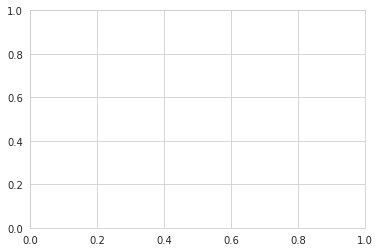

In [268]:
fig, ax = plt.subplots()
simul_perf.plot.scatter(x=0, y=1, c=2, ax=ax, cmap='Blues',alpha=0.25, 
                        figsize=(14, 9), colorbar=True)

eff_pf[eff_pf.index.min():].plot(linestyle='--', lw=2, ax=ax, c='k',
                                 label='Efficient Frontier')

r, sd = max_sharpe_perf
ax.scatter(sd, r, marker='*', color='k', s=500, label='Max Sharpe Ratio PF')

r, sd = min_vol_perf
ax.scatter(sd, r, marker='v', color='k', s=200, label='Min Volatility PF')

kelly_wt = precision_matrix.dot(mean_returns).clip(lower=0).values
kelly_wt /= np.sum(np.abs(kelly_wt))
r, sd = portfolio_performance(kelly_wt, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='D', color='k', s=150, label='Kelly PF')

std = weekly_returns.std()
std /= std.sum()
r, sd = portfolio_performance(std, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='X', color='k', s=250, label='Risk Parity PF')

r, sd = portfolio_performance(np.full(n_assets, 1/n_assets), mean_returns, cov_matrix)
ax.scatter(sd, r, marker='o', color='k', s=200, label='1/n PF')


ax.legend(labelspacing=0.8)
ax.set_xlim(0, eff_pf.max()+.4)
ax.set_title('Mean-Variance Efficient Frontier', fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
fig.tight_layout();